## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [19]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mask_rcnn import utils, visualize
from mask_rcnn import model as modellib
from mask_rcnn.visualize import display_images, random_colors
from mask_rcnn.model import log
from core.mask_rcnn_config import IMAGE_WIDTH

print(IMAGE_WIDTH)

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Root directory of the project
ROOT_DIR = os.getcwd()

# Path to Shapes trained weights
WEIGHTS_PATH = os.path.join(ROOT_DIR, "model", "mask_rcnn_osm_0202.h5")
assert os.path.isfile(WEIGHTS_PATH)

256
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configurations

In [20]:
from core.mask_rcnn_config import MyMaskRcnnConfig

config = MyMaskRcnnConfig()

In [21]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#     RPN_ANCHOR_SCALES = (4,8,16, 32, 64)
#     BACKBONE_STRIDES = [1,2,4, 8, 16]
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #USE_RPN_ROIS = False
#     RPN_ANCHOR_STRIDE = 2
#     RPN_NMS_THRESHOLD = 0.1


config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           osm
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POS

## Notebook Preferences

In [22]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [23]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [30]:
from core.mask_rcnn_config import OsmMappingDataset
from core.train import get_random_datasets
import glob

TRAINING_DATA_DIR = r"D:\training_images\zurich\17"
# TRAINING_DATA_DIR = r"C:\Temp\images\training\256_overfitting"
# TRAINING_DATA_DIR = r"C:\DEV\osm-instance-segmentation\test\data"
# path = os.path.join(TRAINING_DATA_DIR, "**/capetown.bmp")
# path = os.path.join(TRAINING_DATA_DIR, "**/*.tiff")
# path = os.path.join(TRAINING_DATA_DIR, r"some_other_city\23128930_15_1_2.tiff")
print(path)
images = glob.glob(path, recursive=True)

print(images)
random.shuffle(images)
# TRAINING_DATA_DIR = r"C:\Users\Martin\Screenshots"
# images = list(os.listdir(TRAINING_DATA_DIR))


cutoffIndex = int(len(images)*1)
# validationImages = images[cutoffIndex:-1]
validationImages = images

# Validation dataset
# dataset = OsmMappingDataset()
# dataset.load(validationImages)
# dataset.prepare()

dataset, _ = get_random_datasets(100, TRAINING_DATA_DIR, no_logging=True)

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

D:\training_images\some_other_city\23128930_15_1_2.tiff
['D:\\training_images\\some_other_city\\23128930_15_1_2.tiff']
Using training images in:  D:\training_images\zurich\17
733 images found...
Taking randomly 100 images from dataset...
Dataset: OsmMappingDataset
Dataset: InMemoryDataset

Loading 80 images...
Loaded.
Dataset: OsmMappingDataset
Dataset: InMemoryDataset

Loading 20 images...
Loaded.
Images: 80
Classes: ['BG', 'building']


## Load Model

In [25]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", 
                              model_dir=os.path.join(ROOT_DIR, "model"),
                              config=config)

# Load weights
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True)
print("Done")

Loading weights  C:\DEV\osm-instance-segmentation\model\mask_rcnn_osm_0202.h5
Done


## Run Detection

D:\training_images\zurich\17\17_68648_85171.tiff
image ID: osm.D:\training_images\zurich\17\17_68648_85171.tiff (54) 
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


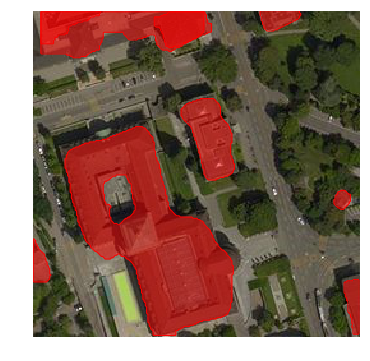

In [37]:
image_id = random.choice(dataset.image_ids)
# image = dataset.load_image(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print(info["path"])
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

colors = random_colors(1)

# Display results
ax = get_ax(1, size=6)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], 
                            ax=ax,
                            show_boxes=False, colors=colors)

img = np.invert(plt.imread(info["path"][:-1]))


# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

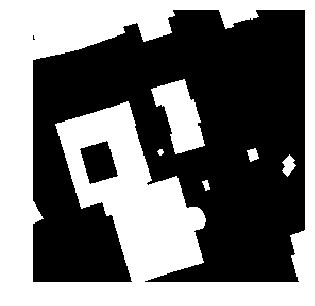

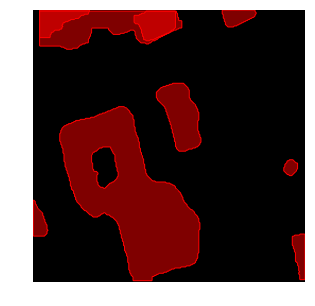

In [38]:
from mask_rcnn.visualize import random_colors

visualize.display_images([img], cmap='Greys', cols=1, figsize=5)
visualize.display_instances(np.zeros((256,256,3)), r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], 
                            ax=None,
                            show_boxes=False, figsize=(5,5), colors=colors)

Nr. instances:  30

POLYGON ((94 234, 95 234, 96 234, 97 234, 98 234, 99 234, 100 234, 101 234, 101 235, 102 235, 103 235, 103 236, 104 236, 104 237, 105 237, 105 238, 106 238, 106 239, 107 239, 107 240, 107 241, 108 241, 108 242, 109 242, 109 243, 109 244, 109 245, 109 246, 109 247, 109 248, 108 248, 108 249, 108 250, 107 250, 107 251, 107 252, 107 253, 107 254, 107 255, 106 255, 106 256, 105 256, 104 256, 103 256, 102 256, 101 256, 100 256, 99 256, 98 256, 97 256, 96 256, 95 256, 94 256, 93 256, 92 256, 91 256, 90 256, 89 256, 88 256, 87 256, 86 256, 85 256, 84 256, 83 256, 82 256, 81 256, 80 256, 79 256, 78 256, 77 256, 76 256, 75 256, 74 256, 73 256, 72 256, 71 256, 70 256, 69 256, 68 256, 67 256, 66 256, 65 256, 64 256, 63 256, 62 256, 61 256, 60 256, 59 256, 58 256, 57 256, 56 256, 55 256, 54 256, 53 256, 52 256, 51 256, 50 256, 49 256, 48 256, 47 256, 46 256, 45 256, 44 256, 43 256, 42 256, 41 256, 40 256, 39 256, 38 256, 37 256, 36 256, 35 256, 34 256, 33 256, 32 256, 31 256, 3

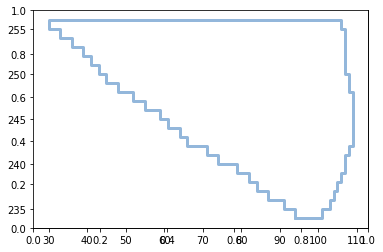

POLYGON ((178 0, 179 0, 180 0, 181 0, 182 0, 183 0, 184 0, 185 0, 186 0, 187 0, 188 0, 189 0, 190 0, 191 0, 192 0, 193 0, 194 0, 195 0, 196 0, 197 0, 197 1, 197 2, 197 3, 197 4, 198 4, 198 5, 198 6, 198 7, 198 8, 198 9, 199 9, 199 10, 199 11, 199 12, 200 12, 200 13, 200 14, 201 14, 201 15, 202 15, 202 16, 202 17, 203 17, 203 18, 203 19, 204 19, 204 20, 205 20, 205 21, 205 22, 206 22, 206 23, 206 24, 207 24, 207 25, 208 25, 208 26, 208 27, 208 28, 208 29, 208 30, 207 30, 207 31, 206 31, 206 32, 205 32, 204 32, 204 33, 203 33, 202 33, 201 33, 201 34, 200 34, 199 34, 198 34, 197 34, 196 34, 195 34, 195 33, 194 33, 193 33, 193 32, 193 31, 192 31, 192 30, 191 30, 191 29, 191 28, 190 28, 190 27, 190 26, 189 26, 189 25, 189 24, 188 24, 188 23, 187 23, 187 22, 187 21, 186 21, 186 20, 186 19, 185 19, 185 18, 185 17, 184 17, 184 16, 184 15, 183 15, 183 14, 182 14, 182 13, 182 12, 181 12, 181 11, 180 11, 180 10, 180 9, 179 9, 179 8, 179 7, 179 6, 179 5, 178 5, 178 4, 178 3, 178 2, 178 1, 178 0))


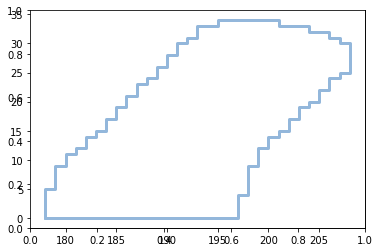

POLYGON ((199 112, 200 112, 201 112, 202 112, 203 112, 204 112, 205 112, 206 112, 207 112, 207 113, 208 113, 209 113, 209 114, 210 114, 210 115, 210 116, 210 117, 211 117, 211 118, 211 119, 211 120, 211 121, 211 122, 211 123, 210 123, 210 124, 210 125, 209 125, 208 125, 208 126, 207 126, 206 126, 206 127, 205 127, 204 127, 203 127, 202 127, 201 127, 201 128, 200 128, 199 128, 198 128, 198 129, 197 129, 196 129, 195 129, 195 130, 194 130, 193 130, 192 130, 192 131, 191 131, 190 131, 189 131, 188 131, 188 132, 187 132, 186 132, 185 132, 184 132, 184 133, 183 133, 182 133, 182 134, 181 134, 180 134, 179 134, 179 135, 178 135, 177 135, 177 136, 176 136, 175 136, 174 136, 174 137, 173 137, 172 137, 171 137, 171 138, 170 138, 169 138, 168 138, 168 139, 167 139, 166 139, 166 140, 165 140, 164 140, 163 140, 163 141, 162 141, 161 141, 160 141, 160 142, 159 142, 158 142, 157 142, 156 142, 156 143, 155 143, 154 143, 153 143, 153 144, 152 144, 151 144, 151 145, 150 145, 150 146, 149 146, 149 147, 

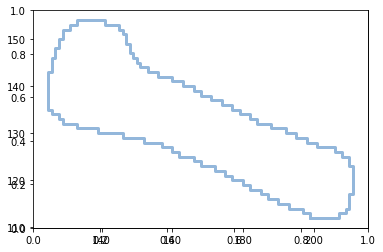

POLYGON ((253 214, 254 214, 255 214, 255 215, 256 215, 256 216, 256 217, 256 218, 256 219, 256 220, 256 221, 256 222, 256 223, 256 224, 256 225, 256 226, 256 227, 256 228, 256 229, 256 230, 256 231, 256 232, 256 233, 256 234, 256 235, 256 236, 256 237, 256 238, 256 239, 256 240, 255 240, 254 240, 254 239, 253 239, 253 240, 252 240, 251 240, 250 240, 249 240, 248 240, 248 241, 247 241, 246 241, 245 241, 245 242, 244 242, 243 242, 242 242, 241 242, 240 242, 239 242, 238 242, 237 242, 237 243, 236 243, 235 243, 234 243, 233 243, 233 242, 232 242, 232 241, 231 241, 231 240, 231 239, 230 239, 230 238, 230 237, 230 236, 230 235, 230 234, 230 233, 230 232, 230 231, 230 230, 230 229, 231 229, 231 228, 232 228, 232 227, 232 226, 233 226, 233 225, 233 224, 233 223, 234 223, 234 222, 235 222, 235 221, 236 221, 236 220, 237 220, 238 220, 238 219, 239 219, 240 219, 240 218, 241 218, 242 218, 243 218, 244 218, 244 217, 245 217, 246 217, 247 217, 247 216, 248 216, 249 216, 250 216, 250 215, 251 215, 

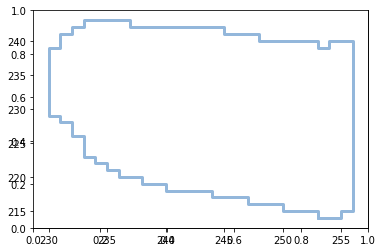

POLYGON ((243 185, 244 185, 245 185, 246 185, 246 186, 247 186, 247 187, 248 187, 248 188, 249 188, 249 189, 249 190, 250 190, 251 190, 251 191, 252 191, 252 192, 252 193, 253 193, 253 194, 254 194, 254 195, 254 196, 254 197, 254 198, 254 199, 254 200, 254 201, 254 202, 253 202, 253 203, 252 203, 252 204, 251 204, 250 204, 250 205, 249 205, 248 205, 247 205, 247 206, 246 206, 245 206, 244 206, 244 207, 243 207, 242 207, 242 208, 241 208, 240 208, 239 208, 239 209, 238 209, 237 209, 236 209, 235 209, 234 209, 233 209, 232 209, 231 209, 231 210, 230 210, 229 210, 228 210, 228 211, 227 211, 226 211, 225 211, 225 212, 224 212, 223 212, 223 213, 222 213, 222 214, 222 215, 221 215, 221 216, 222 216, 222 217, 222 218, 222 219, 222 220, 222 221, 221 221, 221 222, 220 222, 219 222, 218 222, 217 222, 216 222, 215 222, 215 221, 214 221, 214 220, 213 220, 213 219, 213 218, 213 217, 212 217, 212 216, 212 215, 212 214, 211 214, 211 213, 211 212, 211 211, 211 210, 210 210, 210 209, 210 208, 210 207, 

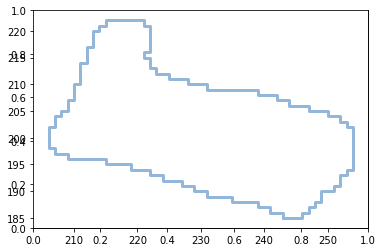

POLYGON ((19 124, 20 124, 21 124, 22 124, 22 125, 23 125, 24 125, 25 125, 26 125, 27 125, 28 125, 29 125, 30 125, 31 125, 31 126, 32 126, 33 126, 33 127, 34 127, 35 127, 35 128, 36 128, 37 128, 37 129, 38 129, 38 130, 39 130, 39 131, 40 131, 40 132, 40 133, 41 133, 41 134, 42 134, 42 135, 43 135, 43 136, 44 136, 44 137, 44 138, 45 138, 45 139, 45 140, 46 140, 46 141, 46 142, 46 143, 47 143, 47 144, 48 144, 48 145, 48 146, 49 146, 49 147, 50 147, 50 148, 50 149, 51 149, 51 150, 51 151, 52 151, 52 152, 53 152, 53 153, 54 153, 54 154, 54 155, 55 155, 55 156, 56 156, 56 157, 57 157, 57 158, 58 158, 58 159, 58 160, 59 160, 59 161, 59 162, 60 162, 60 163, 60 164, 61 164, 61 165, 61 166, 62 166, 62 167, 62 168, 63 168, 63 169, 63 170, 63 171, 64 171, 64 172, 64 173, 65 173, 65 174, 65 175, 66 175, 66 176, 66 177, 67 177, 67 178, 68 178, 68 179, 68 180, 69 180, 69 181, 70 181, 70 182, 70 183, 71 183, 71 184, 71 185, 72 185, 72 186, 72 187, 72 188, 73 188, 73 189, 74 189, 74 190, 74 191, 75 191

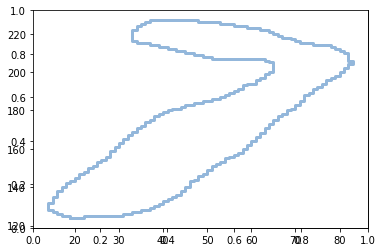

POLYGON ((13 217, 14 217, 14 218, 15 218, 16 218, 17 218, 17 219, 18 219, 19 219, 19 220, 20 220, 20 221, 21 221, 21 222, 21 223, 21 224, 22 224, 22 225, 22 226, 22 227, 23 227, 23 228, 23 229, 23 230, 23 231, 23 232, 23 233, 23 234, 23 235, 23 236, 22 236, 22 237, 22 238, 21 238, 20 238, 19 238, 19 239, 18 239, 17 239, 16 239, 15 239, 14 239, 14 240, 13 240, 12 240, 12 241, 11 241, 10 241, 10 242, 9 242, 8 242, 8 243, 7 243, 7 244, 6 244, 5 244, 4 244, 3 244, 3 245, 2 245, 1 245, 0 245, 0 244, 0 243, 0 242, 0 241, 0 240, 0 239, 0 238, 0 237, 0 236, 0 235, 0 234, 0 233, 0 232, 0 231, 0 230, 0 229, 0 228, 0 227, 0 226, 1 226, 1 225, 2 225, 2 224, 3 224, 3 223, 4 223, 4 222, 5 222, 5 221, 6 221, 7 221, 7 220, 8 220, 8 219, 9 219, 10 219, 11 219, 11 218, 12 218, 13 218, 13 217))



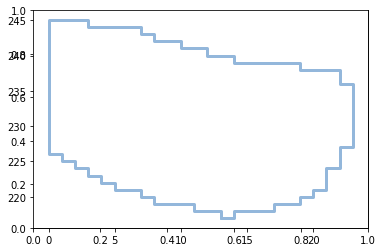

POLYGON ((127 56, 128 56, 129 56, 130 56, 131 56, 131 57, 132 57, 132 58, 133 58, 133 59, 134 59, 134 60, 134 61, 134 62, 135 62, 135 63, 135 64, 136 64, 136 65, 137 65, 137 66, 137 67, 138 67, 138 68, 138 69, 139 69, 139 70, 139 71, 140 71, 140 72, 140 73, 140 74, 140 75, 140 76, 140 77, 139 77, 139 78, 138 78, 137 78, 137 79, 136 79, 135 79, 134 79, 134 80, 133 80, 133 81, 132 81, 131 81, 130 81, 130 82, 129 82, 128 82, 127 82, 126 82, 125 82, 125 81, 124 81, 124 80, 123 80, 123 79, 122 79, 122 78, 121 78, 121 77, 121 76, 120 76, 120 75, 120 74, 119 74, 119 73, 119 72, 118 72, 118 71, 118 70, 117 70, 117 69, 117 68, 117 67, 116 67, 116 66, 116 65, 116 64, 116 63, 116 62, 116 61, 117 61, 118 61, 118 60, 119 60, 120 60, 120 59, 121 59, 122 59, 122 58, 123 58, 124 58, 124 57, 125 57, 126 57, 127 57, 127 56))



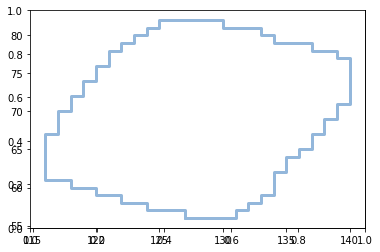

POLYGON ((245 131, 246 131, 247 131, 248 131, 249 131, 250 131, 251 131, 252 131, 253 131, 254 131, 255 131, 255 132, 256 132, 256 133, 256 134, 256 135, 256 136, 256 137, 256 138, 256 139, 256 140, 256 141, 256 142, 256 143, 256 144, 256 145, 256 146, 255 146, 255 147, 254 147, 253 147, 252 147, 252 148, 251 148, 250 148, 249 148, 249 149, 248 149, 247 149, 246 149, 246 150, 245 150, 245 151, 244 151, 243 151, 243 152, 242 152, 241 152, 241 151, 240 151, 240 150, 239 150, 239 149, 238 149, 238 148, 238 147, 238 146, 237 146, 237 145, 237 144, 237 143, 237 142, 236 142, 236 141, 236 140, 235 140, 235 139, 235 138, 235 137, 234 137, 234 136, 234 135, 235 135, 235 134, 236 134, 237 134, 237 133, 238 133, 239 133, 240 133, 241 133, 242 133, 242 132, 243 132, 244 132, 245 132, 245 131))



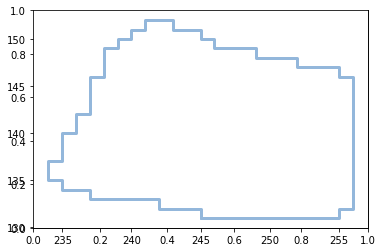

POLYGON ((240 99, 241 99, 242 99, 243 99, 244 99, 245 99, 245 100, 246 100, 246 101, 247 101, 247 102, 247 103, 248 103, 248 104, 248 105, 248 106, 249 106, 249 107, 249 108, 249 109, 249 110, 249 111, 249 112, 249 113, 248 113, 248 114, 247 114, 247 115, 246 115, 245 115, 244 115, 244 116, 243 116, 242 116, 241 116, 240 116, 239 116, 239 117, 238 117, 237 117, 236 117, 236 118, 235 118, 234 118, 233 118, 233 119, 232 119, 231 119, 230 119, 229 119, 229 120, 228 120, 227 120, 227 119, 226 119, 226 118, 225 118, 225 117, 225 116, 225 115, 224 115, 224 114, 224 113, 224 112, 224 111, 224 110, 223 110, 223 109, 223 108, 223 107, 223 106, 223 105, 224 105, 225 105, 225 104, 226 104, 227 104, 228 104, 228 103, 229 103, 230 103, 230 102, 231 102, 232 102, 233 102, 234 102, 234 101, 235 101, 236 101, 237 101, 237 100, 238 100, 239 100, 240 100, 240 99))



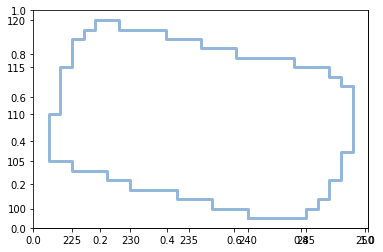

POLYGON ((215 144, 216 144, 217 144, 218 144, 219 144, 220 144, 221 144, 222 144, 223 144, 224 144, 225 144, 225 145, 226 145, 227 145, 227 146, 228 146, 228 147, 229 147, 229 148, 230 148, 230 149, 230 150, 231 150, 231 151, 231 152, 231 153, 231 154, 231 155, 231 156, 230 156, 230 157, 229 157, 229 158, 228 158, 227 158, 227 159, 226 159, 225 159, 224 159, 224 160, 223 160, 222 160, 221 160, 221 161, 220 161, 219 161, 218 161, 218 162, 217 162, 216 162, 216 163, 215 163, 214 163, 214 164, 213 164, 213 165, 212 165, 211 165, 211 166, 210 166, 209 166, 208 166, 207 166, 206 166, 206 167, 205 167, 204 167, 204 166, 203 166, 202 166, 201 166, 201 165, 200 165, 200 164, 200 163, 199 163, 199 162, 198 162, 198 161, 198 160, 197 160, 197 159, 197 158, 197 157, 196 157, 196 156, 196 155, 196 154, 196 153, 197 153, 197 152, 198 152, 198 151, 199 151, 200 151, 200 150, 201 150, 202 150, 202 149, 203 149, 204 149, 205 149, 205 148, 206 148, 207 148, 208 148, 208 147, 209 147, 210 147, 211 147, 

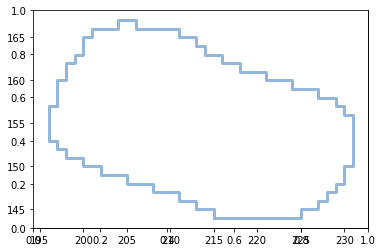

POLYGON ((91 76, 92 76, 93 76, 94 76, 95 76, 96 76, 96 77, 97 77, 97 78, 98 78, 99 78, 99 79, 100 79, 100 80, 101 80, 102 80, 102 81, 103 81, 103 82, 104 82, 104 83, 104 84, 105 84, 105 85, 106 85, 106 86, 106 87, 107 87, 107 88, 107 89, 107 90, 107 91, 107 92, 108 92, 108 93, 108 94, 108 95, 109 95, 109 96, 109 97, 110 97, 110 98, 110 99, 110 100, 110 101, 111 101, 111 102, 111 103, 111 104, 111 105, 111 106, 112 106, 112 107, 112 108, 112 109, 112 110, 113 110, 113 111, 113 112, 114 112, 114 113, 114 114, 115 114, 115 115, 115 116, 115 117, 115 118, 116 118, 116 119, 115 119, 115 120, 115 121, 114 121, 114 122, 113 122, 112 122, 111 122, 111 123, 110 123, 109 123, 108 123, 108 124, 107 124, 106 124, 105 124, 105 125, 104 125, 103 125, 102 125, 101 125, 100 125, 99 125, 98 125, 98 126, 97 126, 96 126, 95 126, 95 127, 94 127, 93 127, 92 127, 91 127, 91 128, 90 128, 89 128, 88 128, 88 129, 87 129, 86 129, 86 130, 85 130, 84 130, 83 130, 83 131, 82 131, 82 132, 81 132, 80 132, 80 133, 79

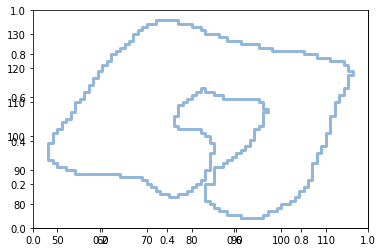

POLYGON ((9 0, 10 0, 11 0, 12 0, 13 0, 14 0, 15 0, 16 0, 17 0, 18 0, 19 0, 20 0, 21 0, 22 0, 23 0, 24 0, 25 0, 26 0, 27 0, 28 0, 29 0, 30 0, 31 0, 31 1, 32 1, 32 2, 33 2, 33 3, 33 4, 34 4, 34 5, 35 5, 35 6, 35 7, 35 8, 35 9, 35 10, 35 11, 36 11, 36 12, 36 13, 37 13, 37 14, 37 15, 38 15, 38 16, 39 16, 39 17, 39 18, 40 18, 40 19, 41 19, 41 20, 41 21, 42 21, 42 22, 42 23, 43 23, 43 24, 43 25, 44 25, 44 26, 44 27, 44 28, 45 28, 45 29, 45 30, 45 31, 45 32, 45 33, 45 34, 45 35, 45 36, 45 37, 44 37, 44 38, 44 39, 44 40, 43 40, 43 41, 42 41, 42 42, 41 42, 41 43, 40 43, 40 44, 39 44, 38 44, 38 45, 37 45, 37 46, 36 46, 36 47, 35 47, 34 47, 34 48, 33 48, 32 48, 32 49, 31 49, 31 50, 30 50, 29 50, 29 51, 28 51, 27 51, 26 51, 25 51, 24 51, 23 51, 23 50, 22 50, 22 49, 22 48, 21 48, 21 47, 21 46, 20 46, 20 45, 20 44, 19 44, 19 43, 18 43, 18 42, 18 41, 17 41, 17 40, 17 39, 16 39, 16 38, 16 37, 15 37, 15 36, 14 36, 14 35, 13 35, 13 34, 13 33, 12 33, 12 32, 12 31, 11 31, 11 30, 10 30, 10 29, 10 28, 9 28,

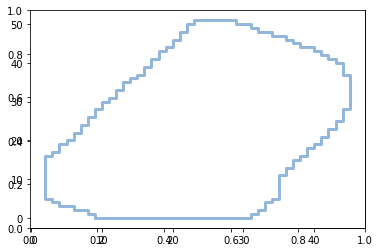

POLYGON ((216 0, 217 0, 218 0, 219 0, 220 0, 221 0, 222 0, 223 0, 224 0, 225 0, 226 0, 227 0, 228 0, 229 0, 230 0, 231 0, 232 0, 233 0, 234 0, 235 0, 236 0, 237 0, 238 0, 238 1, 238 2, 239 2, 239 3, 239 4, 240 4, 240 5, 239 5, 238 5, 237 5, 237 6, 237 7, 238 7, 238 8, 238 9, 239 9, 240 9, 240 10, 240 11, 241 11, 241 12, 242 12, 242 13, 242 14, 242 15, 242 16, 241 16, 241 17, 240 17, 240 18, 239 18, 239 19, 238 19, 238 20, 237 20, 237 21, 236 21, 235 21, 235 22, 234 22, 233 22, 232 22, 231 22, 230 22, 229 22, 229 21, 228 21, 228 20, 227 20, 227 19, 226 19, 226 18, 226 17, 225 17, 225 16, 224 16, 224 15, 224 14, 223 14, 223 13, 222 13, 221 13, 221 12, 220 12, 220 11, 219 11, 219 10, 218 10, 218 9, 217 9, 217 8, 217 7, 216 7, 216 6, 216 5, 215 5, 215 4, 215 3, 215 2, 215 1, 216 1, 216 0))



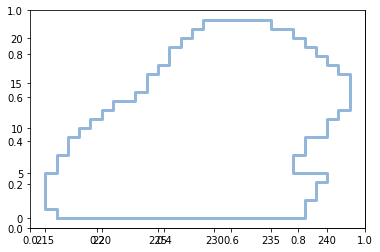

POLYGON ((46 1, 47 1, 48 1, 49 1, 50 1, 51 1, 52 1, 53 1, 54 1, 55 1, 56 1, 57 1, 58 1, 59 1, 60 1, 61 1, 62 1, 63 1, 64 1, 65 1, 66 1, 67 1, 68 1, 69 1, 70 1, 71 1, 72 1, 72 2, 72 3, 72 4, 73 4, 73 5, 73 6, 73 7, 74 7, 74 8, 74 9, 74 10, 74 11, 74 12, 74 13, 75 13, 75 14, 75 15, 75 16, 76 16, 76 17, 76 18, 77 18, 77 19, 77 20, 78 20, 78 21, 78 22, 79 22, 79 23, 79 24, 80 24, 80 25, 79 25, 79 26, 79 27, 79 28, 78 28, 77 28, 77 29, 76 29, 75 29, 75 30, 74 30, 74 31, 73 31, 72 31, 72 32, 71 32, 70 32, 70 33, 69 33, 69 34, 68 34, 67 34, 67 35, 66 35, 65 35, 64 35, 63 35, 62 35, 61 35, 60 35, 59 35, 58 35, 58 34, 57 34, 57 33, 56 33, 56 32, 56 31, 56 30, 55 30, 55 29, 55 28, 54 28, 54 27, 54 26, 54 25, 53 25, 53 24, 53 23, 53 22, 52 22, 52 21, 52 20, 52 19, 51 19, 51 18, 51 17, 50 17, 50 16, 50 15, 49 15, 49 14, 48 14, 48 13, 48 12, 47 12, 47 11, 47 10, 47 9, 46 9, 46 8, 46 7, 46 6, 46 5, 46 4, 46 3, 46 2, 46 1))



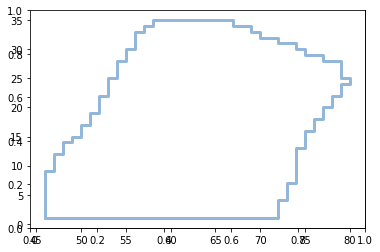

POLYGON ((186 205, 187 205, 188 205, 189 205, 190 205, 190 206, 191 206, 192 206, 192 207, 193 207, 193 208, 193 209, 194 209, 194 210, 195 210, 195 211, 195 212, 195 213, 195 214, 195 215, 195 216, 196 216, 196 217, 196 218, 196 219, 196 220, 196 221, 196 222, 196 223, 195 223, 195 224, 195 225, 195 226, 194 226, 194 227, 194 228, 193 228, 192 228, 192 229, 191 229, 191 230, 190 230, 189 230, 189 231, 188 231, 188 232, 187 232, 187 233, 187 234, 187 235, 187 236, 187 237, 188 237, 188 238, 189 238, 189 239, 190 239, 190 240, 191 240, 191 241, 191 242, 192 242, 192 243, 193 243, 193 244, 194 244, 194 245, 194 246, 195 246, 195 247, 195 248, 195 249, 194 249, 194 250, 193 250, 193 251, 192 251, 191 251, 190 251, 189 251, 189 252, 188 252, 187 252, 187 253, 186 253, 186 254, 185 254, 185 255, 184 255, 183 255, 182 255, 181 255, 180 255, 179 255, 178 255, 177 255, 176 255, 175 255, 174 255, 173 255, 172 255, 171 255, 170 255, 169 255, 168 255, 167 255, 166 255, 165 255, 164 255, 163 255, 

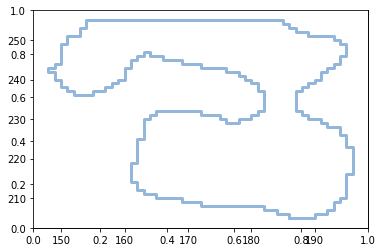

POLYGON ((160 15, 161 15, 162 15, 163 15, 164 15, 164 16, 165 16, 165 17, 166 17, 166 18, 167 18, 167 19, 168 19, 168 20, 168 21, 169 21, 169 22, 169 23, 170 23, 170 24, 170 25, 171 25, 171 26, 171 27, 172 27, 172 28, 172 29, 171 29, 171 30, 170 30, 170 31, 169 31, 169 32, 168 32, 167 32, 166 32, 166 33, 165 33, 164 33, 163 33, 162 33, 161 33, 161 32, 160 32, 160 31, 159 31, 159 30, 159 29, 159 28, 158 28, 158 27, 158 26, 158 25, 158 24, 157 24, 157 23, 157 22, 157 21, 157 20, 157 19, 157 18, 157 17, 158 17, 158 16, 159 16, 160 16, 160 15))



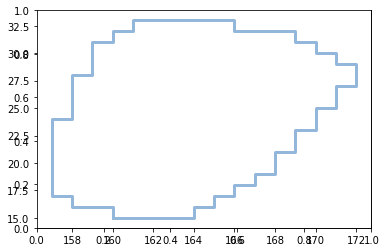

POLYGON ((103 138, 104 138, 105 138, 106 138, 107 138, 108 138, 108 139, 109 139, 109 140, 110 140, 110 141, 111 141, 111 142, 111 143, 112 143, 112 144, 112 145, 113 145, 113 146, 113 147, 114 147, 114 148, 114 149, 114 150, 115 150, 115 151, 115 152, 116 152, 116 153, 116 154, 117 154, 117 155, 117 156, 117 157, 117 158, 116 158, 116 159, 116 160, 115 160, 115 161, 115 162, 114 162, 114 163, 114 164, 113 164, 113 165, 112 165, 112 166, 112 167, 112 168, 112 169, 112 170, 113 170, 113 171, 113 172, 114 172, 114 173, 114 174, 115 174, 115 175, 115 176, 116 176, 116 177, 116 178, 117 178, 118 178, 118 179, 119 179, 120 179, 120 180, 121 180, 121 181, 122 181, 123 181, 123 182, 124 182, 124 183, 125 183, 125 184, 126 184, 126 185, 127 185, 127 186, 128 186, 128 187, 129 187, 130 187, 130 188, 131 188, 131 189, 132 189, 132 190, 133 190, 133 191, 133 192, 133 193, 133 194, 133 195, 133 196, 132 196, 132 197, 131 197, 130 197, 130 198, 129 198, 129 199, 128 199, 127 199, 127 200, 126 200, 

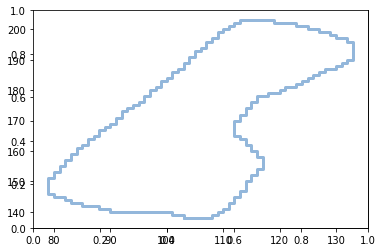

POLYGON ((173 37, 174 37, 175 37, 176 37, 177 37, 177 38, 178 38, 178 39, 179 39, 179 40, 180 40, 180 41, 181 41, 182 41, 182 42, 183 42, 183 43, 183 44, 184 44, 184 45, 185 45, 186 45, 187 45, 188 45, 189 45, 190 45, 191 45, 192 45, 193 45, 194 45, 195 45, 196 45, 197 45, 197 46, 198 46, 199 46, 200 46, 200 47, 201 47, 202 47, 203 47, 204 47, 205 47, 206 47, 207 47, 207 46, 208 46, 209 46, 210 46, 211 46, 212 46, 212 45, 213 45, 214 45, 215 45, 216 45, 216 44, 217 44, 218 44, 218 43, 219 43, 219 42, 220 42, 221 42, 221 41, 222 41, 223 41, 224 41, 224 40, 225 40, 226 40, 227 40, 228 40, 228 41, 229 41, 230 41, 230 42, 230 43, 230 44, 231 44, 231 45, 231 46, 231 47, 231 48, 231 49, 231 50, 232 50, 232 51, 233 51, 233 52, 234 52, 234 53, 235 53, 236 53, 236 54, 237 54, 237 55, 238 55, 238 56, 238 57, 239 57, 239 58, 239 59, 240 59, 240 60, 240 61, 241 61, 241 62, 242 62, 242 63, 242 64, 243 64, 244 64, 244 65, 244 66, 244 67, 244 68, 244 69, 244 70, 244 71, 244 72, 244 73, 243 73, 242 73

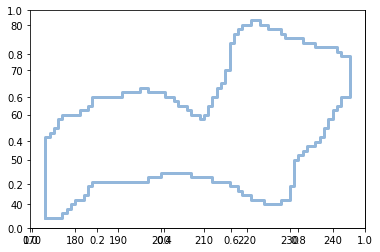

POLYGON ((97 0, 98 0, 99 0, 100 0, 101 0, 102 0, 103 0, 104 0, 105 0, 106 0, 107 0, 108 0, 109 0, 110 0, 111 0, 112 0, 113 0, 114 0, 115 0, 116 0, 117 0, 118 0, 119 0, 120 0, 121 0, 122 0, 123 0, 124 0, 125 0, 126 0, 127 0, 128 0, 129 0, 130 0, 131 0, 132 0, 133 0, 133 1, 133 2, 132 2, 131 2, 131 3, 130 3, 129 3, 129 4, 128 4, 127 4, 127 5, 126 5, 125 5, 125 6, 124 6, 123 6, 123 7, 122 7, 121 7, 121 8, 120 8, 119 8, 119 9, 118 9, 118 10, 117 10, 116 10, 116 11, 115 11, 114 11, 114 12, 113 12, 112 12, 112 13, 111 13, 110 13, 110 14, 109 14, 108 14, 107 14, 107 15, 106 15, 105 15, 105 16, 104 16, 103 16, 103 17, 102 17, 102 18, 101 18, 100 18, 100 19, 99 19, 98 19, 97 19, 97 20, 96 20, 95 20, 94 20, 94 19, 93 19, 92 19, 92 18, 92 17, 91 17, 91 16, 91 15, 90 15, 90 14, 90 13, 90 12, 89 12, 89 11, 89 10, 89 9, 89 8, 89 7, 89 6, 90 6, 90 5, 91 5, 91 4, 92 4, 93 4, 93 3, 94 3, 95 3, 95 2, 96 2, 96 1, 97 1, 97 0))



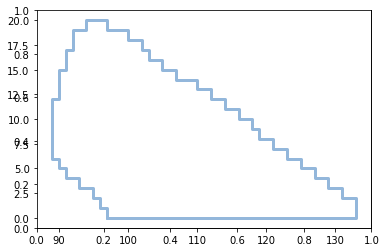

POLYGON ((158 173, 159 173, 160 173, 161 173, 162 173, 163 173, 163 174, 164 174, 164 175, 165 175, 165 176, 166 176, 166 177, 167 177, 167 178, 167 179, 168 179, 168 180, 168 181, 169 181, 169 182, 169 183, 169 184, 170 184, 170 185, 170 186, 170 187, 171 187, 171 188, 171 189, 171 190, 170 190, 170 191, 169 191, 168 191, 168 192, 167 192, 166 192, 165 192, 164 192, 164 193, 163 193, 163 194, 162 194, 161 194, 161 195, 160 195, 159 195, 159 196, 158 196, 157 196, 156 196, 156 197, 155 197, 154 197, 153 197, 153 198, 152 198, 151 198, 150 198, 149 198, 148 198, 148 197, 147 197, 146 197, 146 196, 145 196, 145 195, 144 195, 144 194, 143 194, 143 193, 143 192, 142 192, 142 191, 142 190, 141 190, 141 189, 140 189, 140 188, 140 187, 139 187, 139 186, 139 185, 139 184, 138 184, 138 183, 138 182, 138 181, 138 180, 138 179, 139 179, 139 178, 140 178, 141 178, 142 178, 143 178, 143 177, 144 177, 145 177, 146 177, 147 177, 148 177, 148 176, 149 176, 150 176, 151 176, 151 175, 152 175, 153 175, 

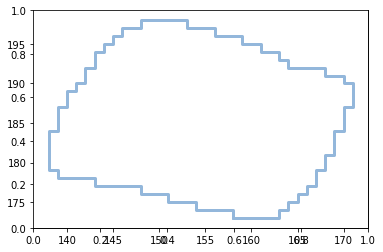

POLYGON ((50 62, 51 62, 52 62, 53 62, 54 62, 55 62, 56 62, 57 62, 58 62, 58 63, 59 63, 59 64, 60 64, 60 65, 61 65, 61 66, 61 67, 61 68, 62 68, 62 69, 62 70, 63 70, 63 71, 63 72, 64 72, 64 73, 64 74, 64 75, 64 76, 64 77, 64 78, 63 78, 63 79, 62 79, 62 80, 61 80, 61 81, 60 81, 59 81, 58 81, 57 81, 56 81, 56 82, 55 82, 54 82, 54 83, 53 83, 52 83, 52 84, 51 84, 51 85, 50 85, 49 85, 49 86, 48 86, 47 86, 47 87, 46 87, 45 87, 45 88, 44 88, 43 88, 42 88, 41 88, 41 87, 40 87, 40 86, 39 86, 39 85, 38 85, 38 84, 37 84, 37 83, 37 82, 36 82, 36 81, 36 80, 36 79, 35 79, 35 78, 35 77, 34 77, 34 76, 34 75, 33 75, 33 74, 33 73, 33 72, 33 71, 34 71, 34 70, 34 69, 35 69, 35 68, 36 68, 37 68, 37 67, 38 67, 39 67, 40 67, 40 66, 41 66, 42 66, 43 66, 44 66, 44 65, 45 65, 46 65, 46 64, 47 64, 48 64, 49 64, 49 63, 50 63, 50 62))



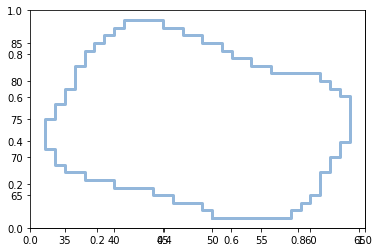

POLYGON ((14 86, 15 86, 16 86, 17 86, 18 86, 19 86, 19 87, 20 87, 21 87, 21 88, 22 88, 22 89, 23 89, 23 90, 23 91, 24 91, 24 92, 24 93, 25 93, 25 94, 25 95, 26 95, 26 96, 26 97, 27 97, 27 98, 28 98, 28 99, 29 99, 29 100, 30 100, 30 101, 31 101, 31 102, 31 103, 31 104, 31 105, 30 105, 30 106, 29 106, 28 106, 28 107, 27 107, 26 107, 26 108, 25 108, 24 108, 24 109, 23 109, 22 109, 21 109, 20 109, 20 110, 19 110, 19 111, 18 111, 17 111, 16 111, 16 112, 15 112, 14 112, 14 113, 13 113, 12 113, 12 114, 11 114, 10 114, 9 114, 9 115, 8 115, 7 115, 6 115, 5 115, 4 115, 4 116, 3 116, 2 116, 1 116, 0 116, 0 115, 0 114, 0 113, 0 112, 0 111, 0 110, 0 109, 0 108, 0 107, 0 106, 0 105, 0 104, 0 103, 0 102, 0 101, 0 100, 0 99, 0 98, 0 97, 0 96, 0 95, 0 94, 1 94, 2 94, 3 94, 4 94, 4 93, 5 93, 6 93, 6 92, 7 92, 7 91, 8 91, 8 90, 9 90, 9 89, 10 89, 11 89, 11 88, 12 88, 12 87, 13 87, 14 87, 14 86))



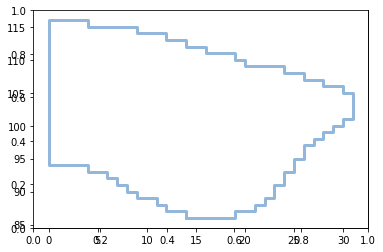

POLYGON ((126 217, 127 217, 128 217, 129 217, 130 217, 131 217, 132 217, 133 217, 134 217, 135 217, 136 217, 136 218, 137 218, 137 219, 138 219, 138 220, 139 220, 139 221, 140 221, 140 222, 140 223, 141 223, 141 224, 141 225, 142 225, 142 226, 142 227, 142 228, 141 228, 141 229, 140 229, 140 230, 139 230, 139 231, 138 231, 138 232, 137 232, 137 233, 136 233, 135 233, 135 234, 134 234, 133 234, 132 234, 132 233, 131 233, 131 232, 130 232, 130 231, 129 231, 129 230, 128 230, 128 229, 128 228, 127 228, 126 228, 126 227, 125 227, 125 226, 124 226, 124 225, 123 225, 123 224, 123 223, 123 222, 123 221, 123 220, 123 219, 123 218, 124 218, 125 218, 126 218, 126 217))



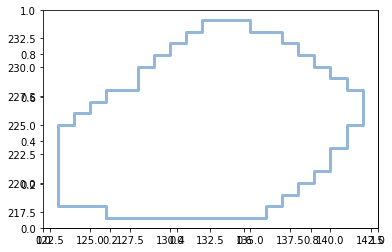

POLYGON ((161 81, 162 81, 163 81, 164 81, 165 81, 166 81, 167 81, 167 82, 168 82, 168 83, 169 83, 169 84, 169 85, 169 86, 169 87, 170 87, 170 88, 170 89, 170 90, 170 91, 170 92, 170 93, 169 93, 169 94, 168 94, 167 94, 166 94, 166 95, 165 95, 164 95, 163 95, 163 96, 162 96, 161 96, 161 97, 160 97, 159 97, 159 98, 158 98, 157 98, 157 99, 156 99, 155 99, 155 100, 154 100, 153 100, 153 101, 152 101, 151 101, 151 102, 150 102, 149 102, 149 103, 148 103, 147 103, 147 104, 146 104, 145 104, 145 105, 144 105, 143 105, 143 106, 142 106, 141 106, 141 107, 140 107, 139 107, 138 107, 137 107, 136 107, 135 107, 135 106, 135 105, 134 105, 134 104, 134 103, 133 103, 133 102, 133 101, 133 100, 133 99, 132 99, 132 98, 132 97, 132 96, 132 95, 131 95, 131 94, 132 94, 132 93, 132 92, 133 92, 134 92, 134 91, 135 91, 136 91, 136 90, 137 90, 138 90, 139 90, 139 89, 140 89, 141 89, 142 89, 142 88, 143 88, 144 88, 145 88, 145 87, 146 87, 147 87, 148 87, 148 86, 149 86, 150 86, 150 85, 151 85, 152 85, 152 84, 1

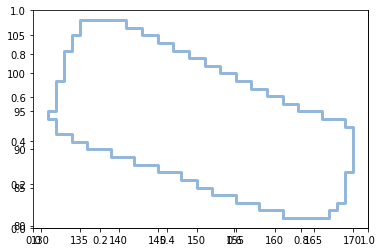

POLYGON ((157 48, 158 48, 159 48, 160 48, 161 48, 161 49, 162 49, 163 49, 163 50, 163 51, 164 51, 164 52, 164 53, 164 54, 165 54, 165 55, 166 55, 166 56, 166 57, 166 58, 166 59, 167 59, 167 60, 167 61, 167 62, 168 62, 168 63, 168 64, 169 64, 169 65, 169 66, 169 67, 170 67, 170 68, 170 69, 170 70, 170 71, 170 72, 170 73, 169 73, 169 74, 169 75, 168 75, 167 75, 166 75, 165 75, 164 75, 163 75, 162 75, 161 75, 161 76, 160 76, 159 76, 158 76, 158 77, 157 77, 156 77, 155 77, 154 77, 153 77, 153 76, 152 76, 152 75, 151 75, 151 74, 151 73, 150 73, 150 72, 150 71, 150 70, 150 69, 149 69, 149 68, 148 68, 148 67, 148 66, 148 65, 148 64, 147 64, 147 63, 147 62, 147 61, 146 61, 146 60, 146 59, 146 58, 145 58, 145 57, 145 56, 145 55, 145 54, 146 54, 146 53, 147 53, 147 52, 148 52, 148 51, 149 51, 150 51, 151 51, 151 50, 152 50, 153 50, 153 49, 154 49, 155 49, 156 49, 157 49, 157 48))



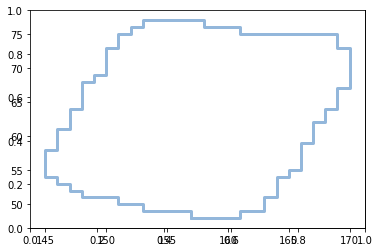

POLYGON ((183 156, 184 156, 185 156, 186 156, 187 156, 187 157, 188 157, 188 158, 188 159, 189 159, 189 160, 190 160, 190 161, 191 161, 191 162, 191 163, 192 163, 193 163, 193 164, 194 164, 194 165, 195 165, 195 166, 195 167, 196 167, 196 168, 196 169, 196 170, 195 170, 195 171, 194 171, 193 171, 193 172, 192 172, 191 172, 190 172, 189 172, 188 172, 187 172, 186 172, 186 173, 185 173, 184 173, 183 173, 182 173, 181 173, 181 174, 180 174, 179 174, 179 175, 178 175, 177 175, 177 176, 176 176, 175 176, 174 176, 173 176, 173 175, 172 175, 172 174, 171 174, 171 173, 171 172, 171 171, 171 170, 171 169, 171 168, 171 167, 171 166, 171 165, 171 164, 171 163, 172 163, 172 162, 173 162, 173 161, 174 161, 174 160, 175 160, 176 160, 176 159, 177 159, 178 159, 178 158, 179 158, 180 158, 181 158, 181 157, 182 157, 183 157, 183 156))



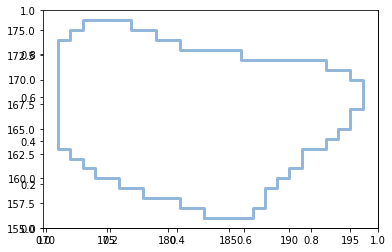

POLYGON ((149 29, 150 29, 151 29, 151 30, 152 30, 153 30, 153 31, 154 31, 154 32, 154 33, 155 33, 156 33, 156 34, 156 35, 157 35, 157 36, 157 37, 157 38, 158 38, 158 39, 158 40, 158 41, 158 42, 157 42, 157 43, 156 43, 155 43, 154 43, 154 42, 153 42, 152 42, 151 42, 150 42, 149 42, 148 42, 147 42, 147 43, 146 43, 145 43, 144 43, 144 44, 143 44, 142 44, 142 45, 141 45, 140 45, 140 46, 139 46, 138 46, 137 46, 136 46, 136 45, 135 45, 135 44, 134 44, 134 43, 134 42, 134 41, 133 41, 133 40, 133 39, 133 38, 133 37, 133 36, 134 36, 134 35, 135 35, 136 35, 136 34, 137 34, 138 34, 138 33, 139 33, 140 33, 141 33, 142 33, 142 32, 143 32, 144 32, 144 31, 145 31, 146 31, 146 30, 147 30, 148 30, 149 30, 149 29))



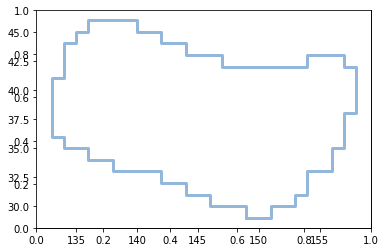

POLYGON ((66 206, 67 206, 68 206, 69 206, 70 206, 70 207, 70 208, 70 209, 70 210, 71 210, 71 211, 71 212, 72 212, 73 212, 73 213, 73 214, 73 215, 72 215, 72 216, 72 217, 72 218, 71 218, 71 219, 71 220, 70 220, 69 220, 69 221, 68 221, 68 222, 67 222, 66 222, 66 223, 65 223, 64 223, 64 224, 63 224, 62 224, 62 225, 61 225, 60 225, 60 226, 59 226, 58 226, 58 227, 57 227, 56 227, 56 228, 55 228, 54 228, 53 228, 53 229, 52 229, 51 229, 50 229, 50 230, 49 230, 48 230, 47 230, 46 230, 45 230, 45 231, 44 231, 43 231, 42 231, 41 231, 40 231, 39 231, 38 231, 37 231, 36 231, 35 231, 35 230, 34 230, 34 229, 34 228, 34 227, 34 226, 34 225, 33 225, 33 224, 33 223, 33 222, 33 221, 33 220, 33 219, 33 218, 33 217, 34 217, 34 216, 35 216, 35 215, 36 215, 37 215, 38 215, 38 214, 39 214, 40 214, 41 214, 42 214, 42 213, 43 213, 44 213, 45 213, 45 212, 46 212, 47 212, 48 212, 48 211, 49 211, 50 211, 51 211, 51 210, 52 210, 53 210, 54 210, 54 209, 55 209, 56 209, 57 209, 58 209, 58 208, 59 208, 60 208, 61 208

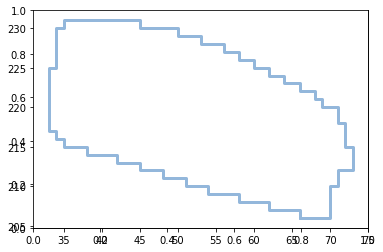

POLYGON ((86 38, 87 38, 88 38, 88 39, 89 39, 90 39, 90 40, 91 40, 91 41, 92 41, 92 42, 92 43, 93 43, 93 44, 94 44, 94 45, 94 46, 95 46, 95 47, 95 48, 94 48, 94 49, 93 49, 93 50, 92 50, 92 51, 91 51, 90 51, 90 52, 89 52, 88 52, 88 53, 87 53, 86 53, 86 54, 85 54, 84 54, 83 54, 82 54, 81 54, 80 54, 80 53, 79 53, 78 53, 77 53, 77 52, 76 52, 76 51, 75 51, 75 50, 74 50, 74 49, 73 49, 73 48, 72 48, 72 47, 72 46, 72 45, 72 44, 73 44, 73 43, 74 43, 74 42, 75 42, 76 42, 76 41, 77 41, 78 41, 79 41, 79 40, 80 40, 81 40, 82 40, 83 40, 83 39, 84 39, 85 39, 86 39, 86 38))


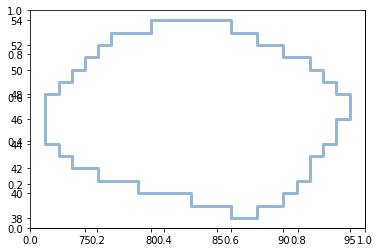

In [119]:
from core.utils import MarchingSquares
from shapely import geometry


# print(results[0]['masks'][:, :, 0])

# for m in results[0]['masks']:
#     print(m[:, :, 0])

nr_instances = results[0]['rois'].shape[0]
print("Nr. instances: ", nr_instances)

# ms = MarchingSquares.from_array(results[0]['masks'][:, :, 3])
# c = ms.find_contour(0.2)
# poly = geometry.Polygon([[x, y] for (x, y) in c])
# print(poly.wkt)

for i in range(nr_instances):
    print("")
    ms = MarchingSquares.from_array(results[0]['masks'][:, :, i])
    c = ms.find_contour()
    poly = geometry.Polygon([[x, y] for (x, y) in c])
    (x, y) = poly.exterior.xy
    plt.show()
    print(poly.wkt)
    fig, axs = plt.subplots()
    ax = fig.add_subplot(111)
    ax.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
#     break



### Precision-Recall

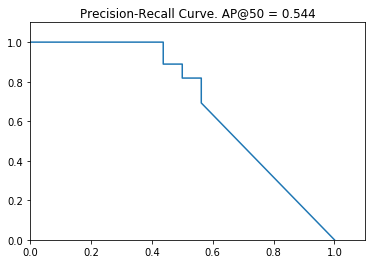

In [128]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

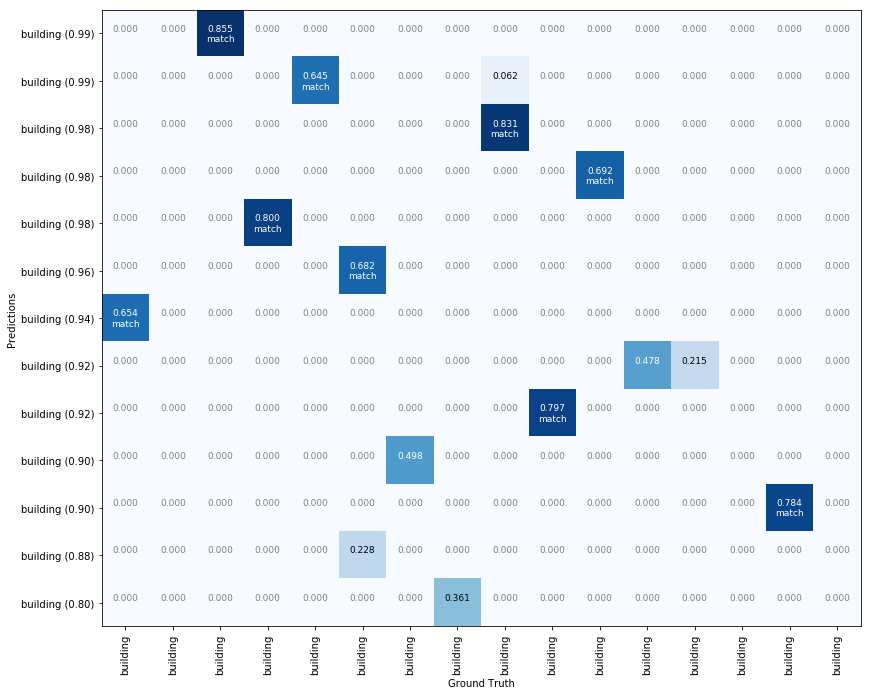

In [129]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [130]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.5373537556055057


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [131]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (16368,)              min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -8.83883  max:    4.53095
positive_anchors         shape: (30, 4)               min:  -16.00000  max:  264.00000
negative_anchors         shape: (226, 4)              min: -298.03867  max:  426.03867
neutral anchors          shape: (16112, 4)            min: -362.03867  max:  554.03867
refined_anchors          shape: (30, 4)               min:    0.00000  max:  256.00000


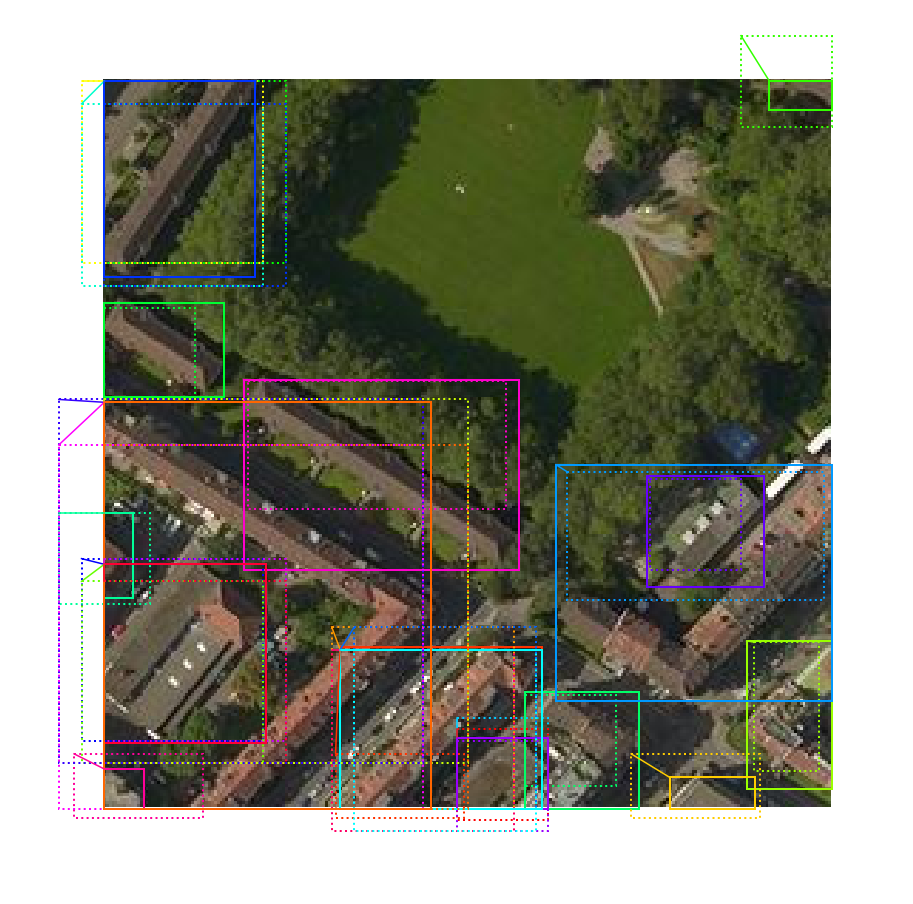

In [132]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [133]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 16368, 2)         min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min: -362.03867  max:  554.03870
refined_anchors          shape: (1, 6000, 4)          min: -397.26840  max:  716.97095
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:  256.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3458.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


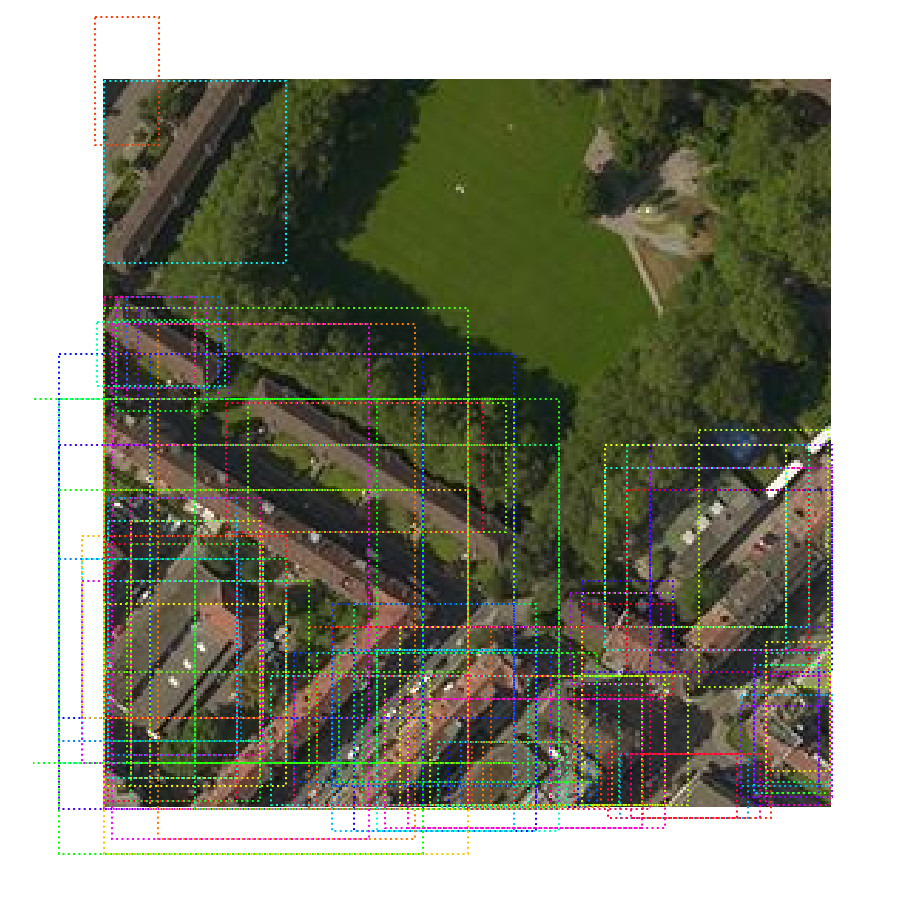

In [134]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

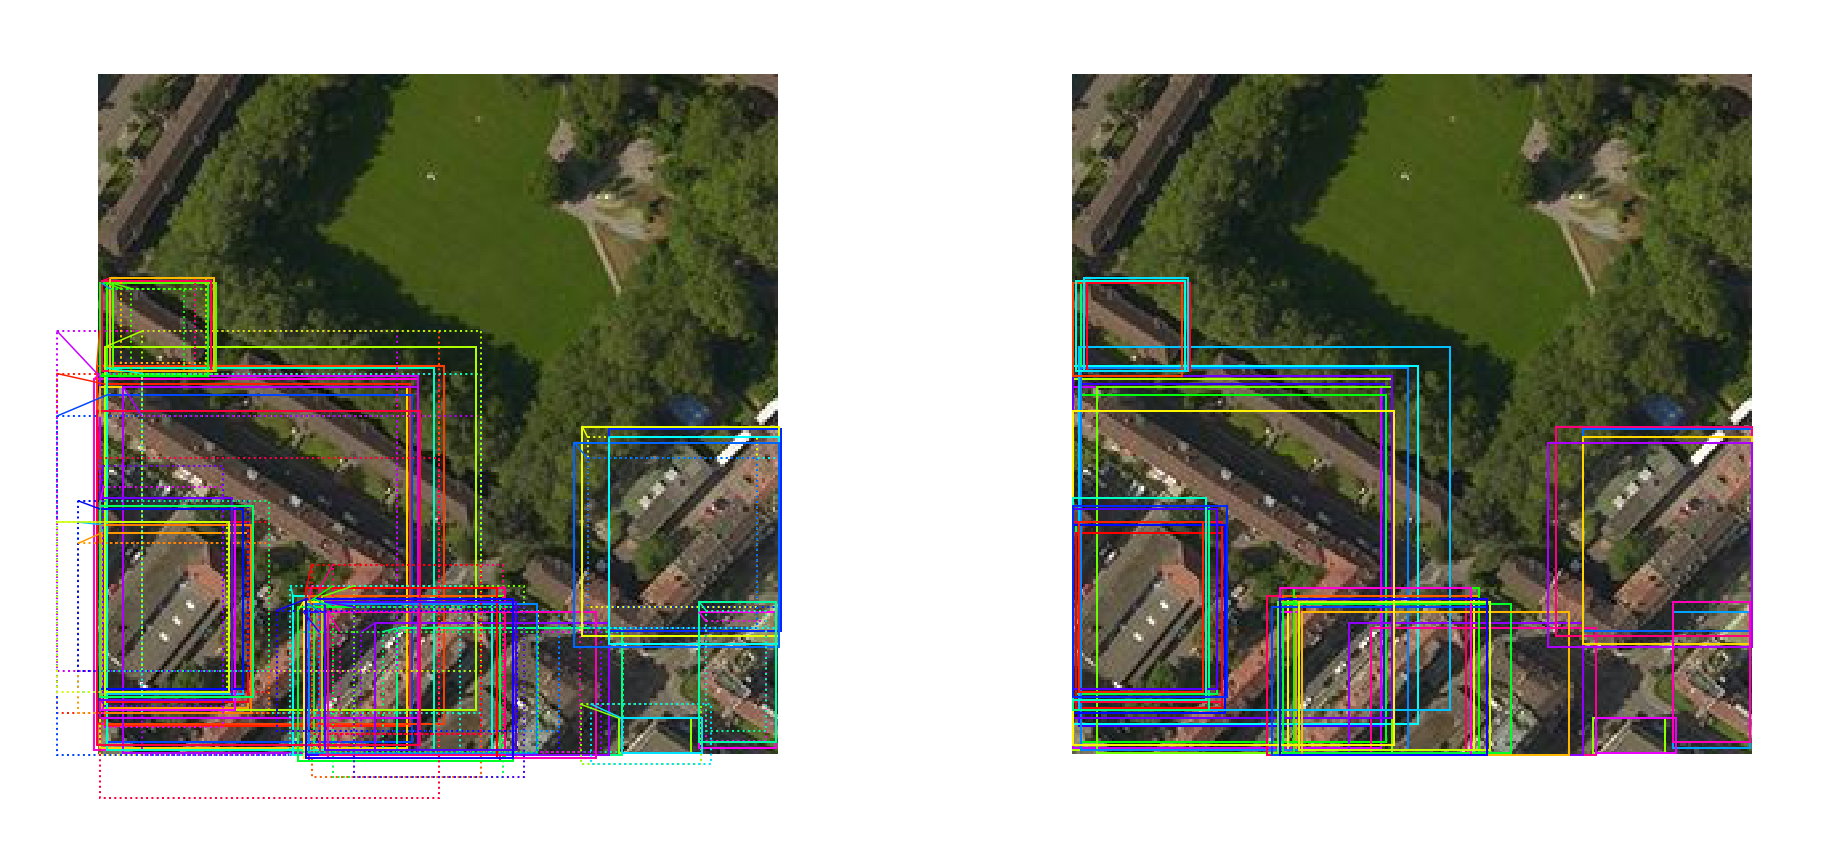

In [135]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

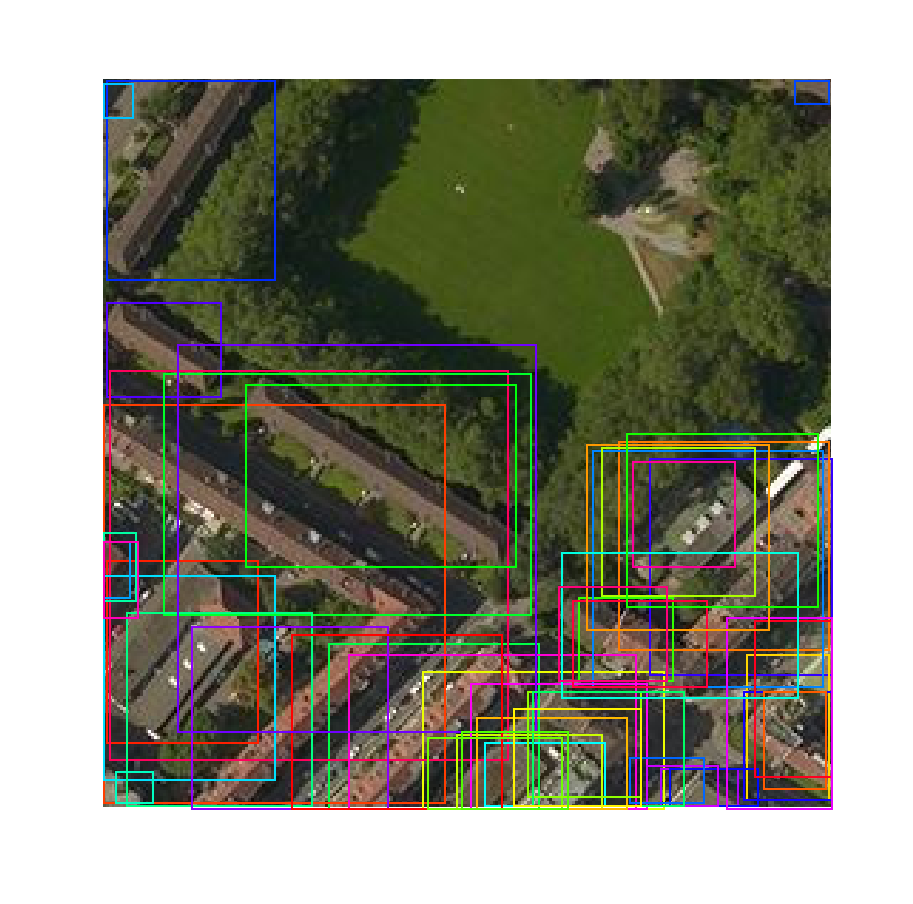

In [136]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

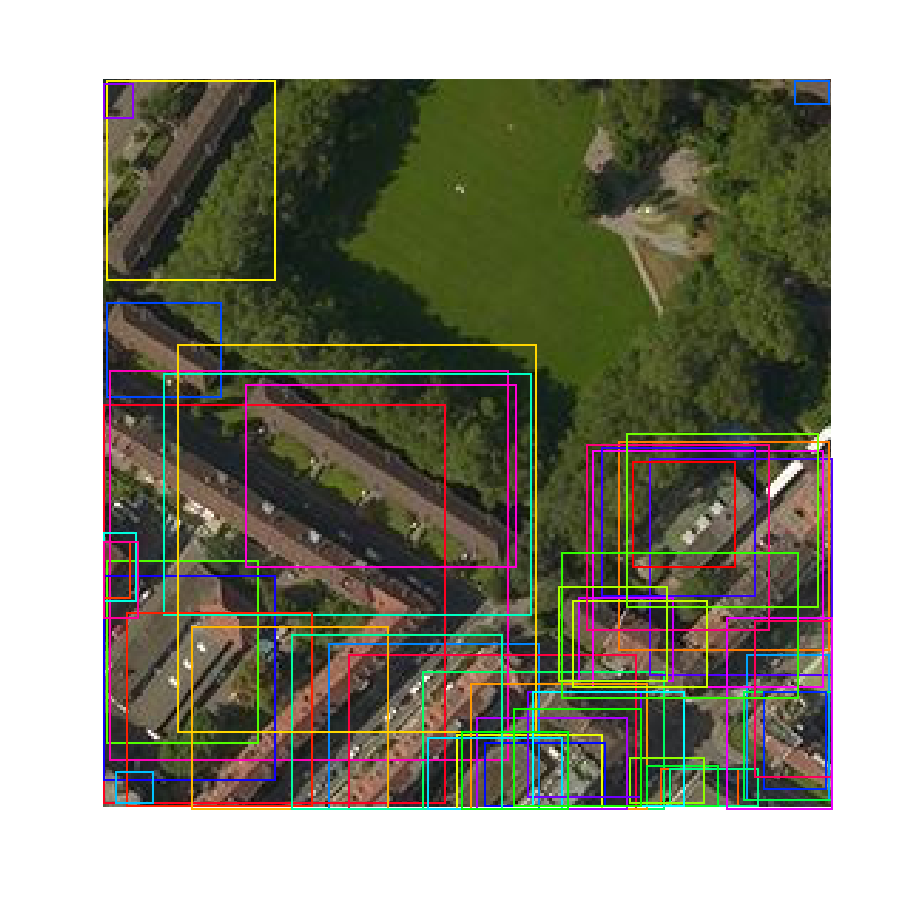

In [137]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [138]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (16368)       Recall: 0.312  Positive anchors: 19
Refined Anchors ( 6000)   Recall: 0.812  Positive anchors: 403
Post NMS Anchors (   50)  Recall: 0.625  Positive anchors: 13


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [139]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 2)          min:    0.00012  max:    0.99988
deltas                   shape: (1, 1000, 2, 4)       min:   -2.86714  max:    2.48999
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00003  max:    0.99756
detections               shape: (1, 100, 6)           min:    0.00000  max:  256.00000


13 detections: ['building' 'building' 'building' 'building' 'building' 'building'
 'building' 'building' 'building' 'building' 'building' 'building'
 'building']


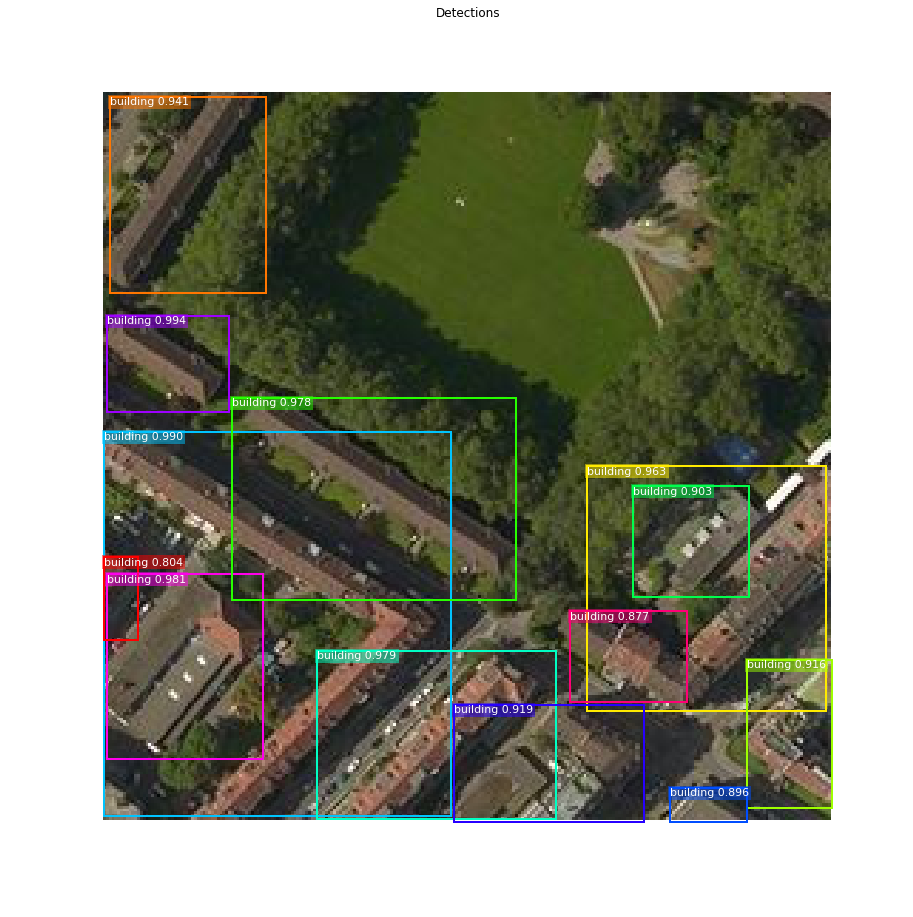

In [140]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [141]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
179 Positive ROIs
[('BG', 821), ('building', 179)]


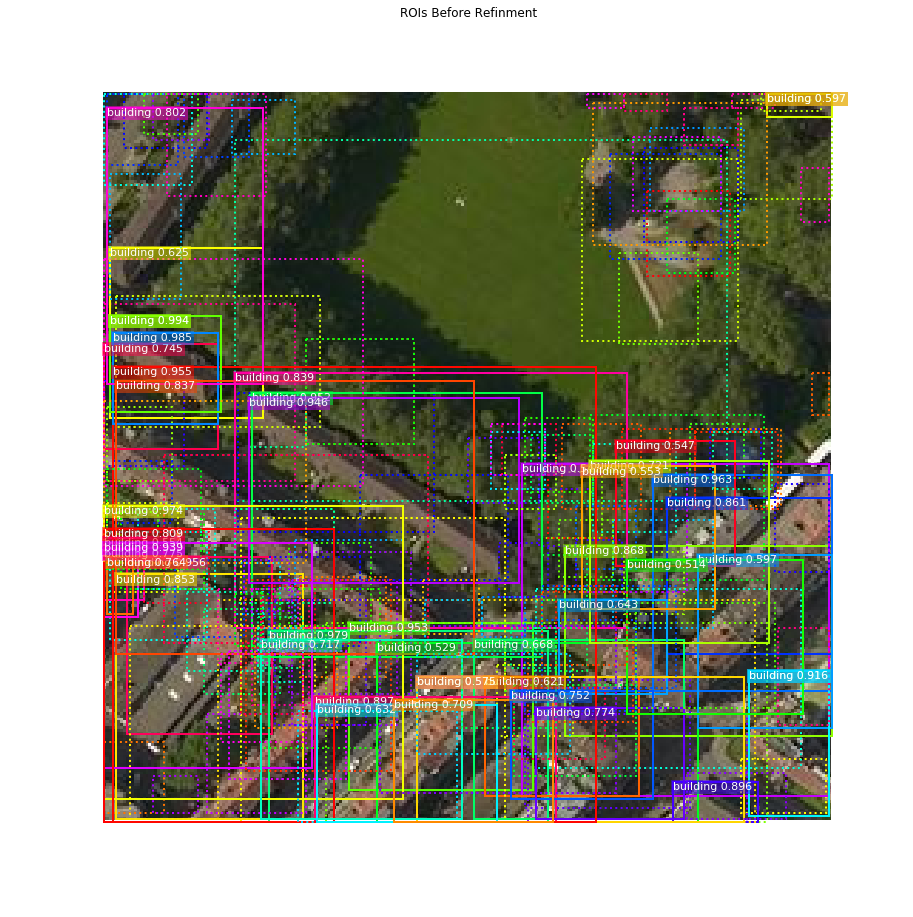

In [142]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinment",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.86714  max:    2.45964
refined_proposals        shape: (1000, 4)             min:  -14.00000  max:  278.00000


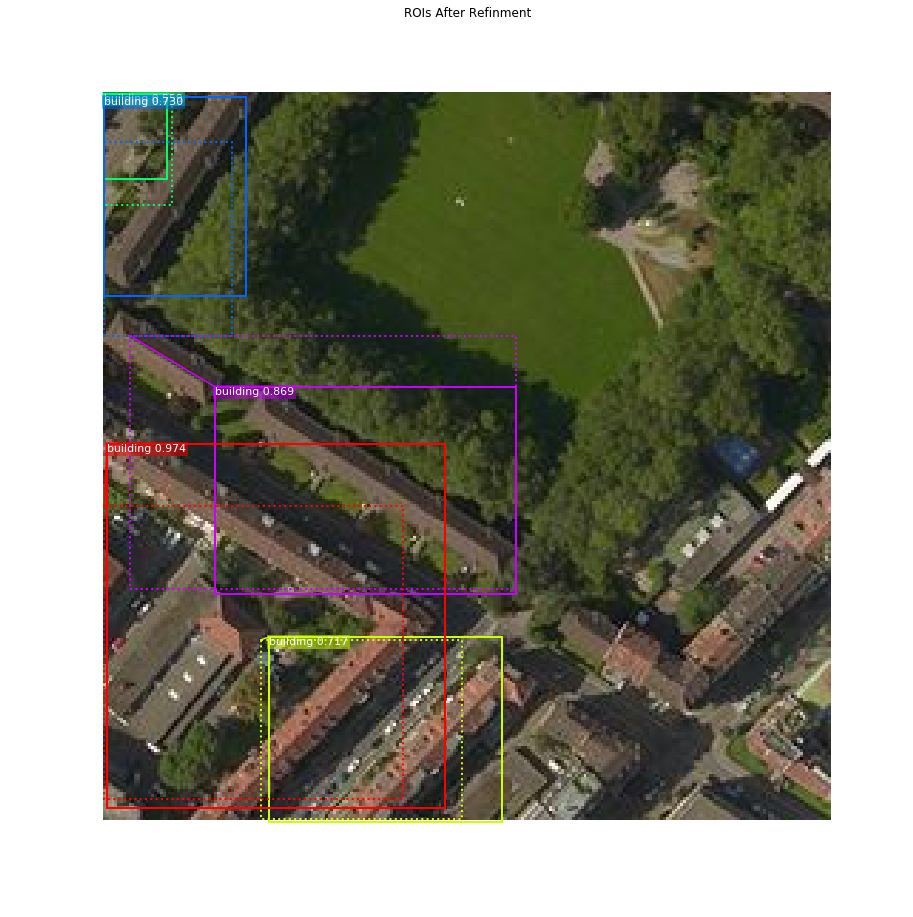

In [143]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinment",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [144]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 179 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  24  25  28  29  30  32  33  34  36  37  38  39  40  41
  42  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59  60  63
  64  65  66  68  72  73  74  76  78  81  83  84  85  87  89  90  93 102
 103 105 106 108 109 110 111 113 121 125 130 132 142 147 149 151 152 153
 154 156 161 163 166 173 176 177 182 188 190 195 212 223 227 228 231 232
 233 234 245 252 255 256 258 262 264 267 268 270 278 294 298 305 312 322
 325 329 330 337 351 359 362 367 369 387 390 395 414 423 426 430 433 443
 455 472 474 526 537 549 556 564 574 581 591 596 678 685 695 720 723 725
 730 741 759 763 773 804 810 882 905 915 927 934 938 939 965 983 986]


In [145]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 117:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  16  18  19  20
  22  24  28  29  30  32  33  34  36  37  38  39  40  42  44  47  52  53
  54  56  57  58  59  64  65  66  68  73  76  81  84  85  87  89  90  93
 102 103 105 109 111 113 125 130 132 142 147 153 154 156 161 166 173 176
 177 182 188 190 227 228 231 232 233 234 245 252 256 258 268 294 298 312
 322 330 337 367 369 390 395 414 526 537 549 556 574 581 695 720 723 730
 741 759 763 905 915 938 939 983 986]


#### Per-Class Non-Max Suppression

In [146]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

building              : [  0   1   2   3   4   5   6   7   8   9  10  11  12  14  16  18  19  20
  22  24  28  29  30  32  33  34  36  37  38  39  40  42  44  47  52  53
  54  56  57  58  59  64  65  66  68  73  76  81  84  85  87  89  90  93
 102 103 105 109 111 113 125 130 132 142 147 153 154 156 161 166 173 176
 177 182 188 190 227 228 231 232 233 234 245 252 256 258 268 294 298 312
 322 330 337 367 369 390 395 414 526 537 549 556 574 581 695 720 723 730
 741 759 763 905 915 938 939 983 986] -> [  3   1  12 166  22 983  10  20   9  57  19 177  39]

Kept after per-class NMS: 13
[  1   3   9  10  12  19  20  22  39  57 166 177 983]


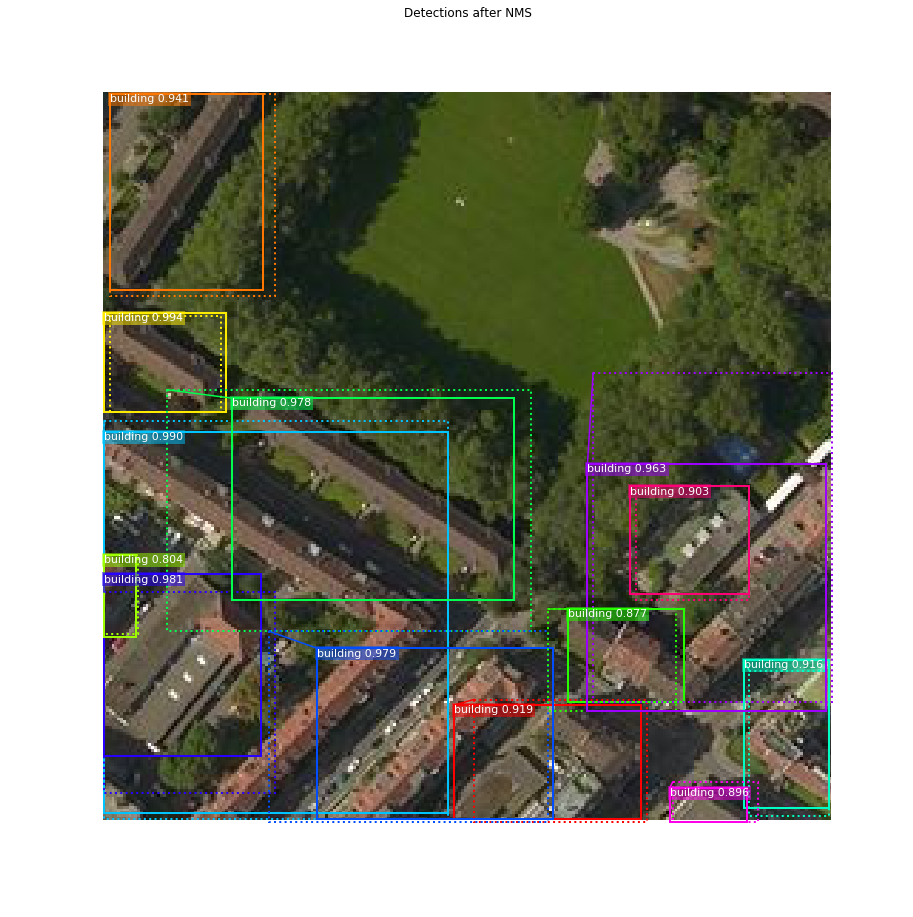

In [147]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:1] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:1] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()